In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
os.chdir('C:\\Users\\Hp\\OneDrive\\Documents\\GitHub\\Thoucentric\\DataSets')

In [2]:
df= pd.read_csv("max_planck_weather_ts.csv")
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [3]:
df.shape

(420551, 15)

Here we have the data for every 10 mins which might be excessive, so we take every 5th row to get an hourly dataset.

In [4]:
df=df[5::6]
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [5]:
df.shape

(70091, 15)

As we can see, the dataset is reduced 5 times.

In [6]:
df.index=pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

In [7]:
df = df.drop(columns=['Date Time'])

<Axes: xlabel='Date Time'>

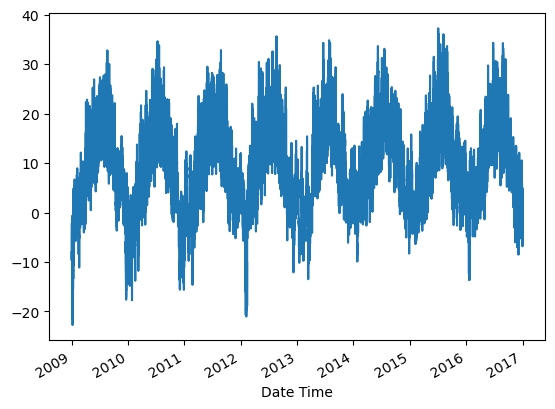

In [8]:
temp=df['T (degC)']
temp.plot()

As the LSTM model takes in input of data in a seerial manner, we convert our dataset into serial data. Something like: 

INPUT - [[[1],[2], [3], [4], [5]]] and  OUTPUT - [6]


INPUT - [[[2],[3], [4], [5], [6]]] and  OUTPUT - [7]


INPUT - [[[3],[4], [5], [6], [7]]] and  OUTPUT - [8]


In [9]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In the above function, we are convert out dataframe to NumPy arrays for manipulation. The given for loop brings it into the format metioned before the function. But as we append this values to an empty python list X and y, we return np.array() of both to convert them back to NumPy arrays for further ML operations.

In [10]:
windowsize = 5
X, y = df_to_X_y(df, windowsize)
#dataset is converted to X and y NumPY arrays
X.shape, y.shape

((70086, 5, 1, 14), (70086, 14))

As the LSTM model input expects a certain input shape, we reshape.

In [11]:
X=X.reshape(X.shape[0], X.shape[1], -1)

In [12]:
X_train, y_train = X[:60000], y[:60000]
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 5, 14),
 (60000, 14),
 (5000, 5, 14),
 (5000, 14),
 (5086, 5, 14),
 (5086, 14))

In [13]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

In [14]:
model = Sequential()
model.add(InputLayer((windowsize, X_train.shape[2])))  # (5, 15)
model.add(LSTM(64))
model.add(Dense(8, activation='relu'))
model.add(Dense(y_train.shape[1], activation='linear'))  # 15 features in the output
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20224     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 14)                126       
                                                                 
Total params: 20,870
Trainable params: 20,870
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.007), metrics=[RootMeanSquaredError()])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 8s 3ms/step - loss: 52420.1094 - root_mean_squared_error: 228.9542 - val_loss: 554.0871 - val_root_mean_squared_error: 23.5391
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1553.1863 - root_mean_squared_error: 39.4105 - val_loss: 552.9459 - val_root_mean_squared_error: 23.5148
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1548.4417 - root_mean_squared_error: 39.3502 - val_loss: 551.8436 - val_root_mean_squared_error: 23.4914
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1541.1639 - root_mean_squared_error: 39.2576 - val_loss: 554.1576 - val_root_mean_squared_error: 23.5406
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 1531.8160 - root_mean_squared_error: 39.1384 - val_loss: 556.2239 - val_root_mean_squared_error: 23.5844
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1520.3512 - root_

In [16]:
train_predictions= model.predict(X_train).flatten()
y_train1=y_train.flatten()
train_results=pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_train1})
train_results

1875/1875 [==============================] - 3s 1ms/step


,Train Predictions,Actuals
0,990.434937,997.71
1,9.120501,-9.67
2,283.074829,263.66
3,4.366444,-10.62
4,75.129395,92.70
...,...,...
839995,9.789823,10.50
839996,1217.395020,1194.50
839997,-5.432654,0.30
839998,-0.668225,0.56


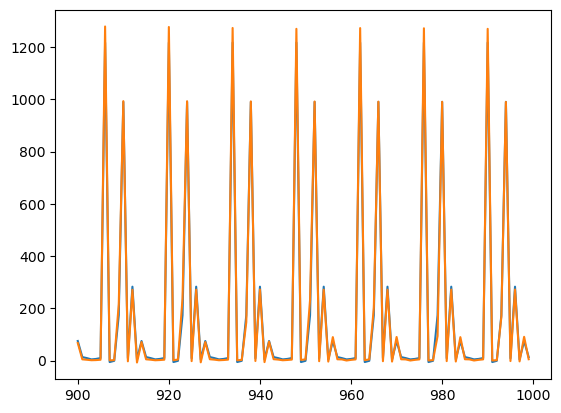

In [17]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][900:1000])
plt.plot(train_results['Actuals'][900:1000])

In [18]:
val_predictions= model.predict(X_val).flatten()
y_val1=y_val.flatten()
val_results=pd.DataFrame(data={'Val Predictions': val_predictions, 'Val Actuals': y_val1})
val_results

157/157 [==============================] - 1s 1ms/step


,Val Predictions,Val Actuals
0,990.434937,993.96
1,9.120501,14.02
2,283.074829,287.68
3,4.366444,7.12
4,75.129395,63.08
...,...,...
69995,9.789823,15.14
69996,1217.395020,1179.64
69997,-5.432654,1.67
69998,-0.668225,2.38


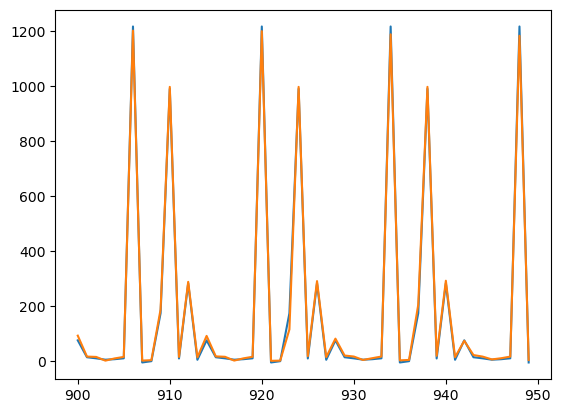

In [19]:
plt.plot(val_results['Val Predictions'][900:950])
plt.plot(val_results['Val Actuals'][900:950])

In [20]:
test_predictions = model.predict(X_test).flatten()
ytest1=y_test.flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Test Actuals': ytest1})
test_results

159/159 [==============================] - 0s 1ms/step


,Test Predictions,Test Actuals
0,990.434937,982.13
1,9.120501,13.99
2,283.074829,288.63
3,4.366444,12.73
4,75.129395,92.10
...,...,...
71199,9.789823,3.31
71200,1217.395020,1292.41
71201,-5.432654,0.56
71202,-0.668225,1.00


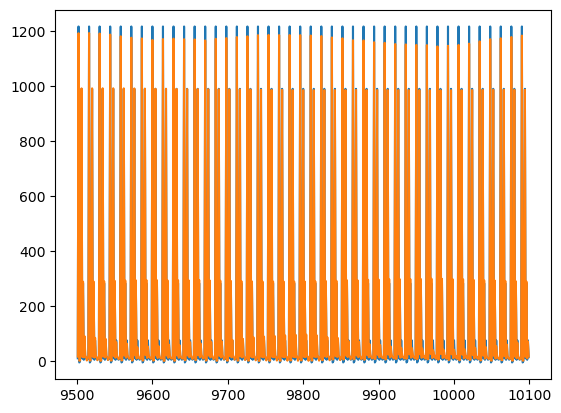

In [21]:
plt.plot(test_results['Test Predictions'][9501:10100])
plt.plot(test_results['Test Actuals'][9501:10100])